# Taxonomic distribution

In [1]:
!pip install pandas matplotlib seaborn biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

# Load the data into a DataFrame
fp = pd.read_csv('fp_vh_metadata.tsv', sep='\t')
fn = pd.read_csv('fn_vh_metadata.tsv', sep='\t')


In [9]:
kingdom_counts_fp = fp['Kingdom'].value_counts()
species_counts_fp = fp['Species'].value_counts()
kingdom_counts_fn = fn['Kingdom'].value_counts()
species_counts_fn = fn['Species'].value_counts()

In [10]:
# Create a threshold option and filter
total_count_fp = len(fp)
total_count_fn = len(fn)
species_abthresh_fp = species_counts_fp[species_counts_fp / total_count_fp * 100 > 4.9]
species_abthresh_fn = species_counts_fn[species_counts_fn / total_count_fn * 100 > 4.9]

# Create a new "Other" category with the count of species below the threshold
species_bethresh_fp = species_counts_fp[species_counts_fp / total_count_fp * 100 <= 4.9].sum()
species_bethresh_fn = species_counts_fn[species_counts_fn / total_count_fn * 100 <= 4.9].sum()
species_abthresh_fp['Other'] = species_bethresh_fp
species_abthresh_fn['Other'] = species_bethresh_fn

Text(0.5, 1.0, 'False negatives')

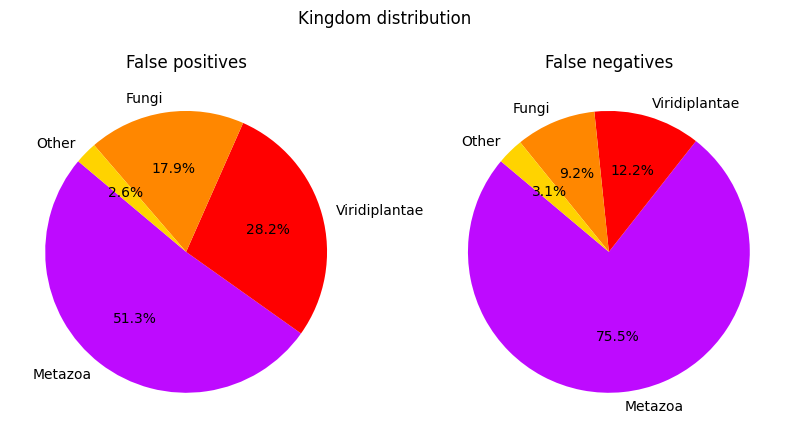

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the pie chart for Kingdom distribution
palette = ['#BE0AFF', '#FF0000', '#FF8700', '#FFD300', '#DEFF0A', '#A1FF0A', '#0AFF99', '#0AEFFF', '#147DF5', '#580AFF']
fig, axs = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('Kingdom distribution')

axs[0].pie(kingdom_counts_fp, labels=kingdom_counts_fp.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[0].set_title('False positives')
axs[1].pie(kingdom_counts_fn, labels=kingdom_counts_fn.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[1].set_title('False negatives')


Text(0.5, 1.0, 'False negatives')

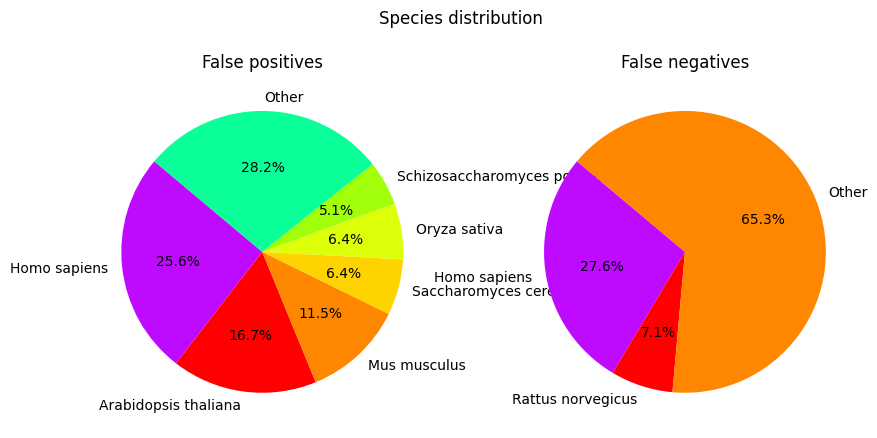

In [12]:
# Plot the pie chart for species distribution
fig, axs = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('Species distribution')

axs[0].pie(species_abthresh_fp, labels=species_abthresh_fp.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[0].set_title('False positives')
axs[1].pie(species_abthresh_fn, labels=species_abthresh_fn.index, autopct='%1.1f%%', startangle=140, colors=palette)
axs[1].set_title('False negatives')


# False positive analysis
Check the portion of FP that have a TM chain in the first 50 residues

In [5]:
import requests, sys
import json

def get_json_by_accession(accession):
    requestURL = "https://www.ebi.ac.uk/proteins/api/proteins/%s" % accession

    r = requests.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()

    json_body = json.loads(r.text)
    return json_body


VALID_EV_CODES = set(["ECO:000269", "ECO:0000255"])

tm = []
for accession in open("FP_vh.txt"):
    accession = accession.strip()
    try:
        protein_json = get_json_by_accession(accession)
    except:
        print("Error: %s" % accession)
    else:
        tm_features = [f for f in protein_json["features"]
                         if f["type"] == "TRANSMEM" and int(f["begin"]) < 90]

        if len(tm_features) > 0:
            evidences = set([e["code"] for f in tm_features for e in f["evidences"]])
            if len(evidences.intersection(VALID_EV_CODES)) > 0:
                tm.append(accession)
                print(accession, evidences, tm_features)
        else:
            print(accession, "No TM")

print(len(tm))


#json.dump(json.loads(responseBody), open("A0PK11.json", 'w'), indent=6)




B2D6M2 No TM
F4IAX1 No TM
G1UH28 No TM
O08574 No TM
O13961 {'ECO:0000255'} [{'type': 'TRANSMEM', 'category': 'TOPOLOGY', 'description': 'Helical; Name=1', 'begin': '35', 'end': '55', 'molecule': '', 'evidences': [{'code': 'ECO:0000255'}]}, {'type': 'TRANSMEM', 'category': 'TOPOLOGY', 'description': 'Helical; Name=2', 'begin': '59', 'end': '79', 'molecule': '', 'evidences': [{'code': 'ECO:0000255'}]}]
O15438 {'ECO:0000255'} [{'type': 'TRANSMEM', 'category': 'TOPOLOGY', 'description': 'Helical; Name=1', 'begin': '33', 'end': '53', 'molecule': '', 'evidences': [{'code': 'ECO:0000255', 'source': {'name': 'PROSITE-ProRule', 'id': 'PRU00441', 'url': 'https://prosite.expasy.org/unirule/PRU00441'}}]}, {'type': 'TRANSMEM', 'category': 'TOPOLOGY', 'description': 'Helical; Name=2', 'begin': '74', 'end': '94', 'molecule': '', 'evidences': [{'code': 'ECO:0000255', 'source': {'name': 'PROSITE-ProRule', 'id': 'PRU00441', 'url': 'https://prosite.expasy.org/unirule/PRU00441'}}]}]
O74954 No TM
O81242 No

Compute the sequence logo of the cleavage site and compare it to the expected one

In [ ]:
import pandas as pd

fn_vh = pd.read_csv('fn_vh.tsv', sep='\t')


sites = []

for i, row in fn_vh.iterrows():
    sp_length = int(row["End"])
    if sp_length >= 13:
        sequence = str(row["Sequence"])
        site = sequence[sp_length - 13:sp_length + 2]
        sites.append(site)


In [ ]:
with open('fn_vh_logo.txt', 'w') as file:
    for sequence in sites:
        file.write(sequence + '\n')


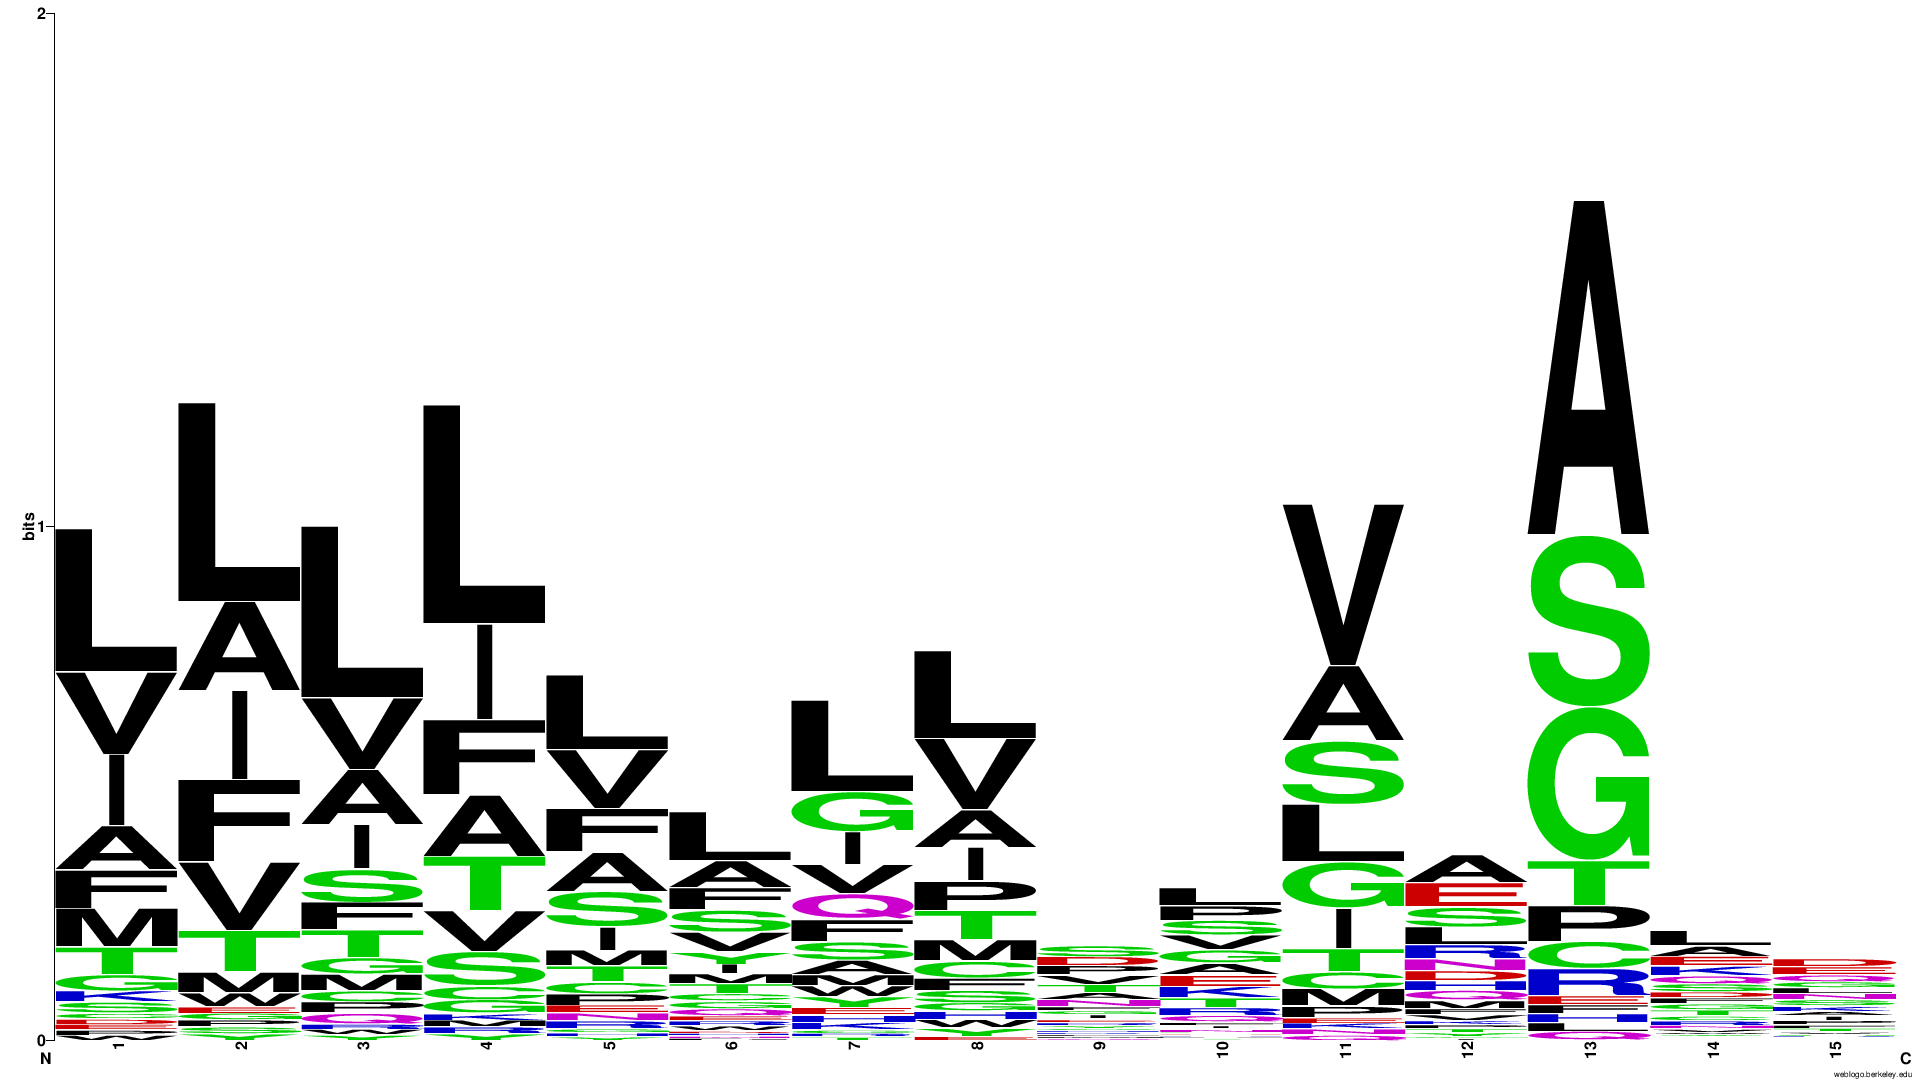

Compare the amino acid distribution of positive examples from training sets up to K residues, benchmarking true positives up to K and benchmarking false negatives up to K

In [7]:
import pandas as pd
import csv

fn_svm = pd.read_csv('fn_metadata.tsv', sep='\t')
tp_svm = pd.read_csv('tp_metadata.tsv', sep='\t')
length = 23
composition = {}
amino = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
comp = []

for j, row in fn_svm.iterrows():
    sequence = str(row["Sequence"])
    signal_peptide = sequence[:length]
    for aa in amino:
        composition[aa] = composition.get(aa, 0) + signal_peptide.count(aa)

for key in composition:
    comp.append((composition[key]))
total = sum(comp)

with open('fn_svm_composition.csv', 'w') as f:
    for key in composition.keys():
        f.write("%s, %s\n" % (key, round((composition[key]/total), 3)))


In [13]:
composition = {}
comp = []
for j, row in tp_svm.iterrows():
    sequence = str(row["Sequence"])
    signal_peptide = sequence[:length]
    for aa in amino:
        composition[aa] = composition.get(aa, 0) + signal_peptide.count(aa)

for key in composition:
    comp.append((composition[key]))
total = sum(comp)

with open('tp_svm_composition.csv', 'w') as f:
    for key in composition.keys():
        f.write("%s, %s\n" % (key, round((composition[key]/total), 3)))

In [9]:
training = pd.read_csv('training_metadata.tsv', sep='\t')
training_SP = training[~pd.isna(training['End'])]

comp = []
training_composition = {}

for i, row in training_SP.iterrows():
    sequence = str(row["Sequence"])
    signal_peptide = sequence[:length]
    for aa in amino:
        training_composition[aa] = training_composition.get(aa, 0) + signal_peptide.count(aa)

for key in training_composition:
    comp.append((training_composition[key]))
total = sum(comp)


In [10]:
with open('training_composition.csv', 'w') as f:
    for key in training_composition.keys():
        f.write("%s, %s\n" % (key, round((training_composition[key]/total), 3)))

Compare length distributions of positive training examples, benchmarking true positives
and benchmarking false negatives

(0.0, 70.0)

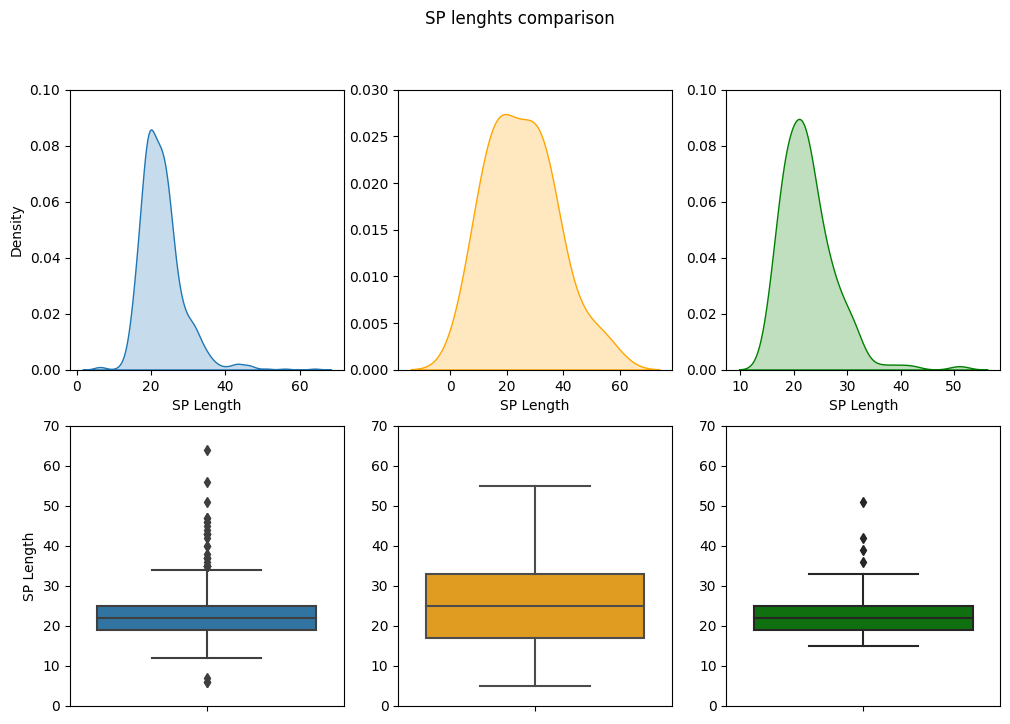

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fn_svm = pd.read_csv('fn_metadata.tsv', sep='\t')
tp_svm = pd.read_csv('tp_metadata.tsv', sep='\t')
training = pd.read_csv('training_metadata.tsv', sep='\t')
training_SP = training[~pd.isna(training['End'])]

fig, axs = plt.subplots(2,3, figsize=(12, 8))
fig.suptitle('SP lenghts comparison')

'''
# histogram
axs[0,0].hist(training_SP['End'], bins=20, edgecolor='k')
axs[0,0].set_xlabel('SP Length')
axs[0,0].set_ylabel('Frequency')
axs[0,0].set_title('training')
axs[0,0].set_ylim(0,250)

axs[0,1].hist(fn_svm['End'], bins=20, color='orange', edgecolor='k')
axs[0,1].set_xlabel('SP Length')
axs[0,1].set_title('FN')
axs[0,1].set_ylim(0,4)

axs[0,2].hist(tp_svm['End'], bins=20, color='green', edgecolor='k')
axs[0,2].set_xlabel('SP Length')
axs[0,2].set_title('TP')
axs[0,2].set_ylim(0,50)
'''

# density plot
sns.kdeplot(training_SP['End'], fill=True, ax=axs[0,0])
axs[0,0].set_xlabel('SP Length')
axs[0,0].set_ylabel('Density')
axs[0,0].set_ylim(0,0.1)

sns.kdeplot(fn_svm['End'], fill=True, color='orange', ax=axs[0,1])
axs[0,1].set_xlabel('SP Length')
axs[0,1].set_ylabel('')
axs[0,1].set_ylim(0,0.03)

sns.kdeplot(tp_svm['End'], fill=True, color='green', ax=axs[0,2])
axs[0,2].set_xlabel('SP Length')
axs[0,2].set_ylabel('')
axs[0,2].set_ylim(0,0.1)

# boxplot
sns.boxplot(y=training_SP['End'], ax=axs[1,0])
axs[1,0].set_ylabel('SP Length')
axs[1,0].set_ylim(0,70)

sns.boxplot(y=fn_svm['End'], color='orange', ax=axs[1,1])
axs[1,1].set_ylabel('')
axs[1,1].set_ylim(0,70)

sns.boxplot(y=tp_svm['End'], color='green', ax=axs[1,2])
axs[1,2].set_ylabel('')
axs[1,2].set_ylim(0,70)


In [ ]:
sns.boxplot(y=training_SP['End'], ax=axs[1,0])
axs[1,0].set_ylabel('SP Length')
axs[1,0].set_ylim(0,70)

sns.boxplot(y=fn_svm['End'], color='orange', ax=axs[1,1])
axs[1,1].set_ylabel('')
axs[1,1].set_ylim(0,70)

sns.boxplot(y=tp_svm['End'], color='green', ax=axs[1,2])
axs[1,2].set_ylabel('')
axs[1,2].set_ylim(0,70)

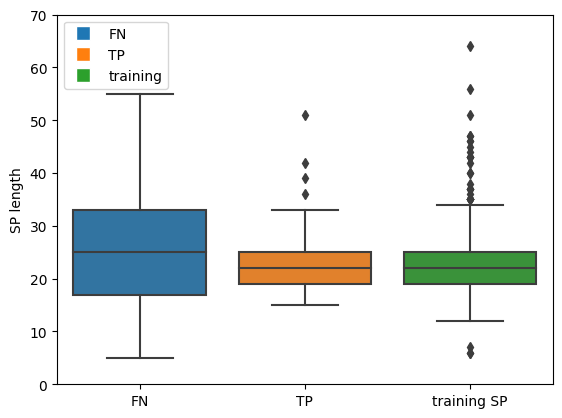

In [20]:
# boxplots adjustment
data = pd.DataFrame({'FN': fn_svm['End'], 'TP': tp_svm['End'], 'training SP': training_SP['End']})
legend_labels = ['FN', 'TP', 'training']
legend_handle = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markersize=10) for color in sns.color_palette()]

# boxplot
asd = sns.boxplot(data=data)
asd.set_ylabel('SP length')
asd.legend(legend_handle, legend_labels, loc='best')
asd.set_ylim(0,70)

sns.set_context(rc={"figure.figsize": (8, 4)})

In [21]:
print(fn_svm['End'].mean())

25.25925925925926
